#### **SET UP**

In [7]:
# Primary data handling and numerical operations
import pandas as pd
import numpy as np

# Financial data retrieval
import yfinance as yf

# Technical analysis tools
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator, SMAIndicator
from ta.volatility import AverageTrueRange
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

# Mathematical operations and plotting
import math
import matplotlib.pyplot as plt

# Random sampling and combinations for parameter search
import random
from itertools import product

# Copying data
import copy

# Miscellaneous
import warnings

#### **BACKTESTING CLASSES**

##### **Common Class**

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

class Common_Class():
    def __init__(self, trading_stocks, hodl_stocks, start, end, interval, capital, transcation_cost, verbose=True):
        """Initializes the Common_Class with trading and holding stocks, date range, interval, initial capital, transaction cost, and verbosity."""
        
        symbol = trading_stocks + hodl_stocks
        self.all_data = {}
        self.position = {}
        self.quantity = {}
        for stock in symbol:
            # Initializing quantities to zero for all stocks
            self.quantity['{}'.format(stock)] = 0

        self.trading_stocks = trading_stocks
        self.hodl_stocks = hodl_stocks
        self.symbol = symbol
        self.start = start
        self.end = end
        self.interval = interval
        self.initial_capital = capital
        self.capital = capital
        self.transaction_cost = transcation_cost
        self.trades = 0
        self.verbose = verbose
        # Dataframe to store trade details
        self.stored_data = pd.DataFrame(columns=['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital'])
        self.benchmark_symbol = "^DJI"
        # Prepare the historical data for the symbols
        self.prepare_data()

    def calculate_benchmark(self):
        """Calculates benchmark metrics such as annual returns, Sharpe ratio, drawdown, and Sortino ratio."""
        
        df = pd.DataFrame()
        # Calculate cumulative sum and daily returns of the benchmark
        df['Total_Stock_Returns_cum_sum'] = self.all_data[f'{self.benchmark_symbol}']["Benchmark_Return"].cumsum()
        df['Total_Stock_Returns'] = self.all_data[f'{self.benchmark_symbol}']["Benchmark_Return"]
        df.index = range(df.shape[0])
        self.benchmark_returns = df

        # Annual gross expected returns calculation
        daily_log_mean_ret = df['Total_Stock_Returns'].mean()
        annual_log_ret = 252 * daily_log_mean_ret
        annual_regular_return = (np.exp(annual_log_ret) - 1) * 100
        benchmak_annual_regular_return = annual_regular_return

        # Annual standard deviation calculation
        daily_regular_std = (np.exp(df['Total_Stock_Returns']) - 1).std()
        annual_regular_std = daily_regular_std * (252 ** 0.5) * 100
        benchmark_annual_regular_std = annual_regular_std

        # Annual Sharpe ratio calculation
        SR = annual_regular_return / annual_regular_std
        benchmark_sharpe_ratio = SR

        # Calculating benchmark capital and returns for each day
        df['benchmark_capital'] = np.exp(df['Total_Stock_Returns_cum_sum']) * self.initial_capital
        df['capital_after_settlement'] = df['benchmark_capital'].shift(-1)

        # Daily returns calculations
        df['capital_regular_returns'] = (df['capital_after_settlement'] / df['benchmark_capital'] - 1)
        df['capital_log_returns'] = np.log(df['capital_after_settlement'] / df['benchmark_capital'])
        df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

        # Drawdown calculation
        df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
        df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]

        # Final benchmark returns calculation
        benchmark_returns = (df['benchmark_capital'].iloc[-1] - self.initial_capital) / self.initial_capital * 100

        # Maximum drawdown calculation
        Drawdown = df["drawdown"].max() * 100
        benchmark_max_drawdown = Drawdown

        # Maximum drawdown period calculation
        zero_periods = df[df['drawdown'] == 0]
        delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
        benchmark_max_drawdown_period = delta_values.max()

        # Annual Sortino ratio calculation
        only_neg_log_returns = df[df['capital_log_returns'] < 0]['capital_log_returns']
        only_neg_regular_returns = np.exp(only_neg_log_returns) - 1
        daily_std_dev_for_sortino = only_neg_regular_returns.std()
        annual_std_dev_for_sortino = daily_std_dev_for_sortino * (252 ** 0.5) * 100
        sortino = annual_regular_return / annual_std_dev_for_sortino
        benchmark_sortino_ratio = sortino

        # Printing benchmark performance metrics
        print("=" * 50)
        print("Performance Metrics for Benchmark")
        print("The total capital at end of Benchmark: {:0.1f}".format(df['benchmark_capital'].iloc[-1]))
        print("The annual regular returns: {:0.2f} %".format(benchmak_annual_regular_return))
        print("The annual regular std deviation: {:0.2f} %".format(benchmark_annual_regular_std))
        print("The annual Sharpe Ratio: {:0.2f}".format(benchmark_sharpe_ratio))
        print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, benchmark_returns))
        print("The maximum drawdown: {:0.2f} %".format(benchmark_max_drawdown))
        print("The maximum drawdown period: {:.2f} days".format(benchmark_max_drawdown_period))
        print("The annual Sortino Ratio: {:0.2f}".format(benchmark_sortino_ratio))
        print("=" * 50)

    def prepare_data(self):
        """Prepares historical stock data including returns, for both trading stocks and benchmark."""
        
        for i in self.symbol:
            # Fetching historical data for each stock
            stock_data = yf.Ticker(i)
            hist_stock = stock_data.history(start=self.start, end=self.end, interval=self.interval)
            bt_data = pd.DataFrame()
            bt_data["Close_Price"] = hist_stock["Close"]
            bt_data["High_Price"] = hist_stock["High"]
            bt_data["Low_Price"] = hist_stock["Low"]
            # Calculating daily returns
            bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
            bt_data = bt_data.dropna()
            self.all_data['{}'.format(i)] = bt_data
        
        # Fetching benchmark historical data
        benchmark_data = yf.Ticker(self.benchmark_symbol)
        hist_stock = benchmark_data.history(start=self.start, end=self.end, interval=self.interval)
        bt_data["Benchmark_Close_Price"] = hist_stock["Close"]
        bt_data["Benchmark_High_Price"] = hist_stock["High"]
        bt_data["Benchmark_Low_Price"] = hist_stock["Low"]
        bt_data["Benchmark_Return"] = np.log(bt_data["Benchmark_Close_Price"] / bt_data["Benchmark_Close_Price"].shift(1))
        bt_data = bt_data.dropna()
        self.all_data[f'{self.benchmark_symbol}'] = bt_data
        # Calculate benchmark metrics after data preparation
        self.calculate_benchmark()

    def close_graph(self, stock):
        """Plots the closing prices for a specified stock."""
        
        i = str(stock)
        plt.figure(figsize=(15, 5))
        # Plotting close prices of the stock
        plt.plot(self.all_data[i]["Close_Price"], color='black', label='Price', linestyle='dashed')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Close Prices of {}".format(i))
        plt.legend()
        plt.grid()
        plt.show()

    def return_date_price(self, bar, stock):
        """Returns the date and price of a stock at a specific bar index."""
        
        i = str(stock)
        date = str(self.all_data[i].index[bar])[:10]
        price = self.all_data[i].Close_Price.iloc[bar]
        return date, price

    def realised_balance(self, bar):
        """Prints the realised balance at a specific bar index."""
        
        date, price = self.return_date_price(bar, self.symbol[0])
        print("Date :{} | Realised Balance: {:0.1f}".format(date, self.capital))

    def unrealised_balance(self, bar):
        """Calculates unrealised balance for all stocks at a specific bar index."""
        
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub = ub + self.quantity['{}'.format(stock)] * price

    def total_balance(self, bar):
        """Calculates the total balance (realised + unrealised) for all stocks at a specific bar index."""
        
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub = ub + self.quantity['{}'.format(stock)] * price
        tb = ub + self.capital
        return tb

    def store_results(self, trade, date, position, price, symbol, quantity, capital):
        """Stores details of each trade in the stored_data DataFrame."""
        
        trade_detail = pd.DataFrame({'trade': pd.Series(trade), 'date': pd.Series(date), 'position': pd.Series(position),
                                     'price': pd.Series(price), 'symbol': pd.Series(symbol),
                                     'quantity': pd.Series(quantity), 'capital': pd.Series(capital)})
        self.stored_data = pd.concat([self.stored_data, trade_detail])

    def performance_plots(self):
        """Plots the performance of the strategy including cumulative returns, equity curve, and drawdown."""
        
        Final_result_data = self.Final_result_data
        interval = str(self.interval)
        f, ax = plt.subplots(2, 3, figsize=(20, 10))

        # Plot 1: Cumulative log returns of included stocks
        plt.subplot(2, 3, 1)
        for stock in self.symbol:
            plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
        plt.title("Cum Log returns of included stocks")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        # Plot 2: Histogram of strategy returns
        plt.subplot(2, 3, 2)
        plt.hist(Final_result_data['capital_log_returns'], bins=35, label='Strategy Returns', linestyle='dashed')
        plt.title("Histogram of Strategy returns")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        # Plot 3: Strategy vs Benchmark Return Curve
        plt.subplot(2, 3, 3)
        plt.plot(self.benchmark_returns.index, self.benchmark_returns['Total_Stock_Returns_cum_sum'], color='red', label='Benchmark Returns', linestyle='dashed')
        shifted_B_index = Final_result_data.index + (self.benchmark_returns.index[-1] - Final_result_data.index[-1])
        plt.plot(shifted_B_index, Final_result_data['capital_returns_log_cum_sum'].dropna(), label='Strategy Returns')
        plt.title("Strategy Vs Benchmark Return Curve")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        # Plot 4: Drawdown
        plt.subplot(2, 3, 4)
        plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
        plt.plot(Final_result_data["Cum_Max"].dropna(), label='Max Drawdown')
        plt.title("Drawdown")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        # Plot 5: Equity Curve
        plt.subplot(2, 3, 5)
        plt.plot(Final_result_data["capital"].dropna(), label='Equity $')
        plt.title("Equity Curve")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        # Remove empty subplot
        plt.suptitle("Performance Plots")
        f.delaxes(ax[1, 2])
        plt.show()

    def performance(self):
        """Calculates the performance of the strategy including returns, drawdown, and risk ratios."""
        
        df = pd.DataFrame()
        df['capital'] = self.stored_data.groupby('date').agg({'capital': 'mean'})

        trade_start_date = df['capital'].index[0]
        trade_end_date = df['capital'].index[-1]

        for stock in self.symbol:
            A = (self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist())
            df['Returns_{}'.format(stock)] = A

        c = df.columns
        df['Total_Stock_Returns'] = (df.loc[:, c[-len(self.symbol):]].sum(1)) / len(self.symbol)
        df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
        df.index = range(df.shape[0])

        df['capital_after_settlement'] = df['capital'].shift(-1)
        df['capital_regular_returns'] = (df['capital_after_settlement'] / df['capital'] - 1)
        df['capital_log_returns'] = np.log(df['capital_after_settlement'] / df['capital'])
        df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

        df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
        df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]

        df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True)
        df = df.dropna()

        Final_result_data = df

        daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
        annual_log_ret = 252 * daily_log_mean_ret
        annual_regular_return = (np.exp(annual_log_ret) - 1) * 100
        self.annual_regular_return = annual_regular_return

        daily_regular_std = (np.exp(Final_result_data['capital_log_returns']) - 1).std()
        annual_regular_std = daily_regular_std * (252 ** 0.5) * 100
        self.annual_regular_std = annual_regular_std

        SR = annual_regular_return / annual_regular_std
        self.sharpe_ratio = SR

        returns = (self.capital - self.initial_capital) / self.initial_capital * 100
        self.returns = returns

        Drawdown = Final_result_data["drawdown"].max() * 100
        self.max_drawdown = Drawdown

        zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]
        delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
        self.max_drawdown_period = delta_values.max()

        only_neg_log_returns = Final_result_data[Final_result_data['capital_log_returns'] < 0]['capital_log_returns']
        only_neg_regular_returns = np.exp(only_neg_log_returns) - 1

        daily_std_dev_for_sortino = only_neg_regular_returns.std()
        annual_std_dev_for_sortino = daily_std_dev_for_sortino * (252 ** 0.5) * 100

        sortino = annual_regular_return / annual_std_dev_for_sortino
        self.sortino_ratio = sortino

        self.Final_result_data = Final_result_data

    def performance_results(self):
        """Prints the performance metrics of the trading strategy."""
        
        print("=" * 50)
        print("Performance Metrics")
        print("The total capital at end of strategy: {:0.1f}".format(self.capital))
        print("The annual regular returns: {:0.2f} %".format(self.annual_regular_return))
        print("The annual regular std deviation: {:0.2f} %".format(self.annual_regular_std))
        print("The annual Sharpe Ratio: {:0.2f}".format(self.sharpe_ratio))
        print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, self.returns))
        print("The maximum drawdown: {:0.2f} %".format(self.max_drawdown))
        print("The maximum drawdown period: {:.2f} days".format(self.max_drawdown_period))
        print("The annual Sortino Ratio: {:0.2f}".format(self.sortino_ratio))
        print("The total trades taken by the strategy: {}".format(self.trades))
        print("=" * 50)

    def buy_order(self, bar, stock, quantity=None, dollar=None):
        """Executes a buy order for a specific stock with given quantity or dollar value."""
        
        date, price = self.return_date_price(bar, stock)
        if quantity is None:
            quantity = int(dollar / price)
        self.capital = self.capital - ((quantity * price) * (1 + self.transaction_cost))
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
        self.trades = self.trades + 1
        self.position['{}'.format(stock)] = 1
        tb = self.total_balance(bar)
        self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)

        if self.verbose:
            print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity, stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock, self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)

    def sell_order(self, bar, stock, quantity=None, dollar=None):
        """Executes a sell order for a specific stock with given quantity or dollar value."""
        
        date, price = self.return_date_price(bar, stock)
        if quantity is None:
            quantity = int(dollar / price)
        self.capital = self.capital + ((quantity * price) * (1 - self.transaction_cost))
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
        self.trades = self.trades + 1
        self.position['{}'.format(stock)] = -1
        tb = self.total_balance(bar)
        self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)

        if self.verbose:
            print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity, stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock, self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)

    def last_trade(self, bar):
        """Closes out all open positions for all stocks at the specified bar index."""
        
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            last_quantity = self.quantity['{}'.format(stock)]
            self.capital = self.capital + last_quantity * price
            self.quantity['{}'.format(stock)] = 0
            self.trades = self.trades + 1
            if self.position['{}'.format(stock)] == -1:
                last_quantity = -last_quantity
                self.position['{}'.format(stock)] = 1
            else:
                last_quantity = last_quantity
                self.position['{}'.format(stock)] = -1
            tb = self.total_balance(bar)
            self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

            if self.verbose:
                print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity, stock, price, last_quantity * price))


##### **Grid Search**

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)
def objective_function(strategy, ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier, \
    trading_stocks, hodl_stocks, testing_start, testing_end, initial_capital):
    #print('testing for: ')
    #print(f'ema_window {ema_window}')
    #print(f'bb_window {bb_window}')
    #print(f'bb_deviation {bb_dev}')
    #print(f'atr_window {atr_window}')
    #print(f'sl_multiplier {sl_multiplier}')
    #print(f'tp_multiplier {tp_multiplier}')

    A = strategy(trading_stocks, hodl_stocks, testing_start, testing_end, "1d", initial_capital, 0.00, False)
    A.run_strategy(ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier)
    
    # Calculate the performance of the strategy
    A.performance()
    #A.performance_results()
    
    # Extract the final return from the performance metrics
    returns = A.capital - initial_capital
    
    return returns

def randomized_cv_search(strategy, param_grid, trading_stocks, hodl_stocks, testing_start, testing_end, initial_capital, n_iter):
    best_params = best_params = {
                'ema_window': 200,
                'bb_window': 20,
                'bb_dev': 1.5,
                'atr_window': 14,
                'sl_multiplier': 3,
                'tp_multiplier': 3
            }
    ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier = [200, 20, 1.5, 14, 3, 3]
    best_score = objective_function(strategy, ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier, \
    trading_stocks, hodl_stocks, testing_start, testing_end, initial_capital)

    # Generate all possible parameter combinations
    param_combinations = list(product(
        param_grid['ema_window'], param_grid['bb_window'], param_grid['bb_dev'],
        param_grid['atr_window'], param_grid['sl_multiplier'], param_grid['tp_multiplier']
    ))

    # Randomly select a subset of parameter combinations
    random.seed(2024)  # For reproducibility
    sampled_combinations = random.sample(param_combinations, min(n_iter, len(param_combinations)))

    for params in sampled_combinations:
        ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier = params

        # Run the objective function to evaluate the current parameter combination
        score = objective_function(strategy, ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier, \
    trading_stocks, hodl_stocks, testing_start, testing_end, initial_capital)

        # Check if this combination gives a better score
        if score > best_score:
            best_score = score
            best_params = {
                'ema_window': ema_window,
                'bb_window': bb_window,
                'bb_dev': bb_dev,
                'atr_window': atr_window,
                'sl_multiplier': sl_multiplier,
                'tp_multiplier': tp_multiplier
            }

    # Print the best parameter set and score found
    print(f"Best Parameters from Randomized CV: {best_params}")
    print(f"Best Total Return from Randomized CV: {best_score}")

    return best_params

##### **Portfolio of All Volatile Stocks**

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

class All_volatile(Common_Class):
    
    def update_trailing_sl(self, stock, price, atr, sl_multiplier):
        """Updates the trailing stop loss for a given stock based on ATR and stop loss multiplier."""
        
        old_stop_loss = self.stop_loss_price['{}'.format(stock)]
        if self.position['{}'.format(stock)] == 1:
            new_stop_loss = price - (atr * sl_multiplier)
            if new_stop_loss > old_stop_loss:
                self.stop_loss_price['{}'.format(stock)] = new_stop_loss

        if self.position['{}'.format(stock)] == -1:
            new_stop_loss = price + (atr * sl_multiplier)
            if new_stop_loss < old_stop_loss:
                self.stop_loss_price['{}'.format(stock)] = new_stop_loss

    def update_tp_sl(self, stock, price, atr, sl_multiplier, tp_multiplier):
        """Sets the initial stop loss and take profit for a given stock based on ATR, stop loss, and take profit multipliers."""
        
        if self.position['{}'.format(stock)] == 1:
            self.take_profit_price['{}'.format(stock)] = price + (tp_multiplier * atr)
            self.stop_loss_price['{}'.format(stock)] = price - (sl_multiplier * atr)

        if self.position['{}'.format(stock)] == -1:
            self.take_profit_price['{}'.format(stock)] = price - (tp_multiplier * atr)
            self.stop_loss_price['{}'.format(stock)] = price + (sl_multiplier * atr)

    def go_long(self, bar, stock, quantity=None, dollar=None):
        """Executes a long position for the specified stock, either closing short or opening a new position."""
        
        if self.position['{}'.format(stock)] == -1:
            self.position['{}'.format(stock)] = 0
            self.buy_order(bar, stock, quantity=-self.quantity['{}'.format(stock)])
        if quantity:
            self.buy_order(bar, stock, quantity=quantity)
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
            else:
                dollar = self.capital / len(self.symbol)
            self.buy_order(bar, stock, dollar=dollar)

    def go_short(self, bar, stock, quantity=None, dollar=None):
        """Executes a short position for the specified stock, either closing long or opening a new position."""
        
        if self.position['{}'.format(stock)] == 1:
            self.position['{}'.format(stock)] = 0
            self.sell_order(bar, stock, quantity=self.quantity['{}'.format(stock)])
        if quantity:
            self.sell_order(bar, stock, quantity=quantity)
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
            else:
                dollar = self.capital / len(self.symbol)
            self.sell_order(bar, stock, dollar=dollar)

    def conditionGenerator(self, ema, bb_low, bb_high, close_price, bar):
        """Generates trading conditions based on EMA and Bollinger Bands for long or short positions."""
        
        if close_price.iloc[bar] < bb_low.iloc[bar] and close_price.iloc[bar] > ema.iloc[bar]:
            return 1  # Condition to go long
        elif close_price.iloc[bar] > bb_high.iloc[bar] and close_price.iloc[bar] < ema.iloc[bar]:
            return -1  # Condition to go short
        else:
            return 1

    def run_strategy(self, ema, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier):
        """Runs the trading strategy using specified indicators and parameters."""
        
        self.stop = False
        self.trades = 0
        self.capital = self.initial_capital

        self.take_profit_price = {}
        self.stop_loss_price = {}

        # Preparing data with EMA, Bollinger Bands, and ATR indicators for each stock
        for stock in self.symbol:
            self.quantity['{}'.format(stock)] = 0
            self.position['{}'.format(stock)] = 0
            self.take_profit_price['{}'.format(stock)] = 0
            self.stop_loss_price['{}'.format(stock)] = 0

            # Calculate EMA for each stock
            self.all_data[stock]['EMA'] = self.all_data[stock]['Close_Price'].ewm(span=ema, adjust=False).mean()

            # Calculate Bollinger Bands for each stock
            bollingerbands = BollingerBands(self.all_data[stock]['Close_Price'], window=bb_window, window_dev=bb_dev)
            high = bollingerbands.bollinger_hband()
            low = bollingerbands.bollinger_lband()
            mid = bollingerbands.bollinger_mavg()

            self.all_data[stock]['bb_high'] = high
            self.all_data[stock]['bb_low'] = low
            self.all_data[stock]['bb_mid'] = mid

            # Calculate ATR for each stock
            indicator_atr = AverageTrueRange(high=self.all_data[stock]['High_Price'],
                                             low=self.all_data[stock]['Low_Price'],
                                             close=self.all_data[stock]['Close_Price'],
                                             window=atr_window, fillna=False)
            atr = indicator_atr.average_true_range()
            self.all_data[stock]['ATR'] = atr

        # Running the strategy for each bar from EMA to the last available data bar
        for bar in range(ema, len(self.all_data['{}'.format(self.symbol[0])])):
            tb = self.total_balance(bar)
            if tb < 0:
                print("negative capital")
                self.last_trade(bar)
                self.stop = True
                break

            for stock in self.symbol:
                tp = self.take_profit_price['{}'.format(stock)]
                sl = self.stop_loss_price['{}'.format(stock)]
                curr_atr = self.all_data[stock]['ATR'].iloc[bar]
                date, price = self.return_date_price(bar, stock)
                num_of_stocks_with_no_position = sum(1 for value in self.position.values() if value == 0)
                if num_of_stocks_with_no_position != 0:
                    amount_to_trade = self.capital / num_of_stocks_with_no_position
                else:
                    amount_to_trade = self.capital / len(self.position)

                # Check take profit or stop loss for long positions
                if self.position['{}'.format(stock)] == 1:
                    if price >= tp or price <= sl:
                        self.sell_order(bar, stock, quantity=self.quantity['{}'.format(stock)])
                        self.position['{}'.format(stock)] = 0

                # Check take profit or stop loss for short positions
                if self.position['{}'.format(stock)] == -1:
                    if price <= tp or price >= sl:
                        self.buy_order(bar, stock, quantity=-self.quantity['{}'.format(stock)])
                        self.position['{}'.format(stock)] = 0

                # Update trailing stop loss if in a position
                if self.position['{}'.format(stock)] in [1, -1]:
                    self.update_trailing_sl(stock, price, curr_atr, sl_multiplier)

                # Generate conditions to go long if no position or short
                if self.position['{}'.format(stock)] in [0, -1]:
                    if self.conditionGenerator(self.all_data[stock]['EMA'], self.all_data[stock]['bb_low'],
                                               self.all_data[stock]['bb_high'], self.all_data[stock]['Close_Price'],
                                               bar) == 1:
                        self.go_long(bar, stock, dollar=amount_to_trade)
                        self.update_tp_sl(stock, price, curr_atr, sl_multiplier, tp_multiplier)
                        continue

                # Generate conditions to go short if no position or long
                if self.position['{}'.format(stock)] in [0, 1]:
                    if self.conditionGenerator(self.all_data[stock]['EMA'], self.all_data[stock]['bb_low'],
                                               self.all_data[stock]['bb_high'], self.all_data[stock]['Close_Price'],
                                               bar) == -1:
                        self.go_short(bar, stock, dollar=amount_to_trade)
                        self.update_tp_sl(stock, price, curr_atr, sl_multiplier, tp_multiplier)
                        continue

                # Store trade details for further analysis
                store_quantity = abs(self.quantity['{}'.format(stock)])
                tb = self.total_balance(bar)
                self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)

        # Closing all trades at the end of the last bar
        if self.stop == False:
            self.last_trade(bar)


##### **RandomCV Search on Train Period**

Performance Metrics for Benchmark
The total capital at end of Benchmark: 934665.3
The annual regular returns: 9.37 %
The annual regular std deviation: 14.43 %
The annual Sharpe Ratio: 0.65
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 86.9 %
The maximum drawdown: 18.42 %
The maximum drawdown period: 289.00 days
The annual Sortino Ratio: 0.86
Performance Metrics
The total capital at end of strategy: 910146.6
The annual regular returns: 10.16 %
The annual regular std deviation: 12.31 %
The annual Sharpe Ratio: 0.83
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 82.0 %
The maximum drawdown: 17.49 %
The maximum drawdown period: 181.00 days
The annual Sortino Ratio: 1.16
The total trades taken by the strategy: 1066


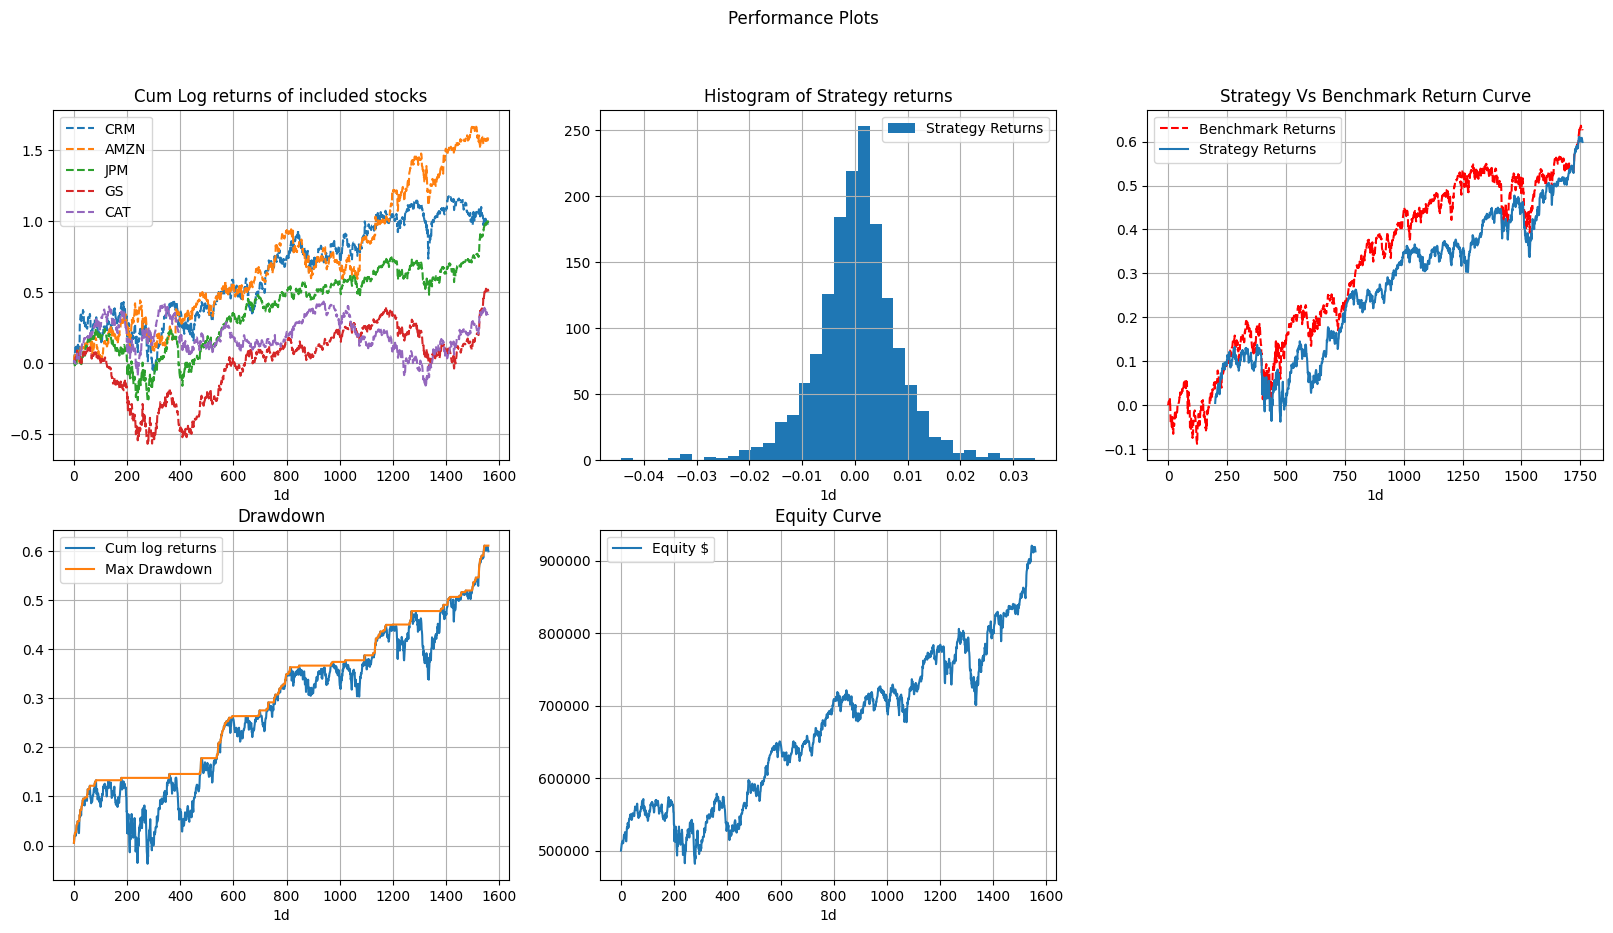

Performance Metrics for Benchmark
The total capital at end of Benchmark: 934665.3
The annual regular returns: 9.37 %
The annual regular std deviation: 14.43 %
The annual Sharpe Ratio: 0.65
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 86.9 %
The maximum drawdown: 18.42 %
The maximum drawdown period: 289.00 days
The annual Sortino Ratio: 0.86
Performance Metrics for Benchmark
The total capital at end of Benchmark: 934665.3
The annual regular returns: 9.37 %
The annual regular std deviation: 14.43 %
The annual Sharpe Ratio: 0.65
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 86.9 %
The maximum drawdown: 18.42 %
The maximum drawdown period: 289.00 days
The annual Sortino Ratio: 0.86
Performance Metrics for Benchmark
The total capital at end of Benchmark: 934665.3
The annual regular returns: 9.37 %
The annual regular std deviation: 14.43 %
The annual Sharpe Ratio: 0.65
The returns on investment from 2010-01-01 to 2016-12-31 by this

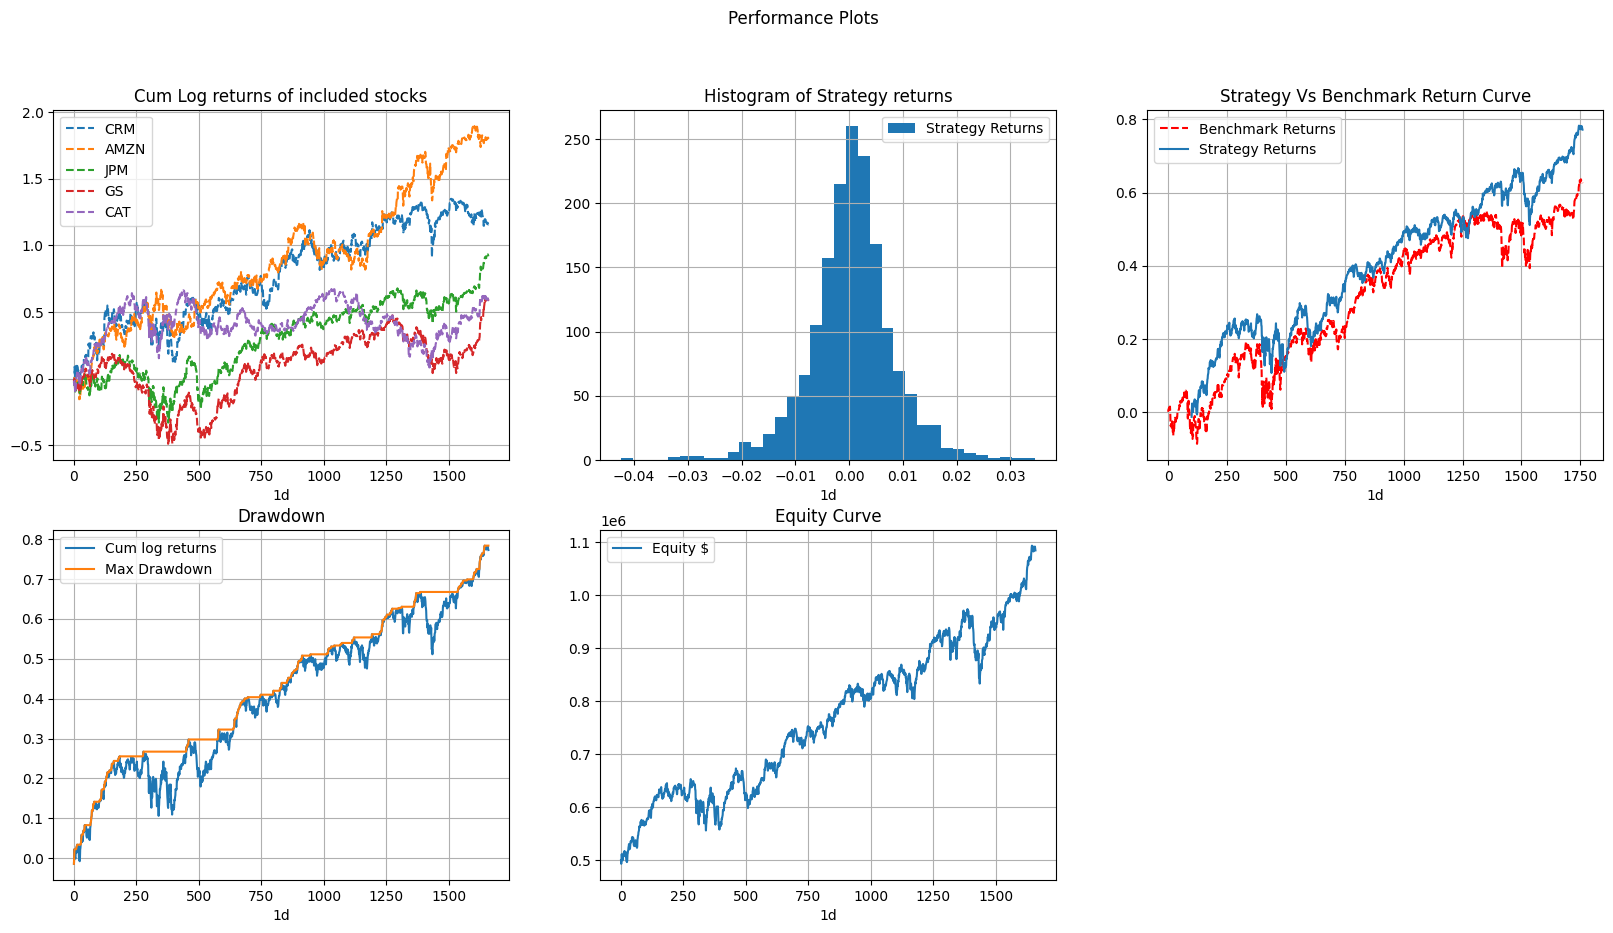

Performance Metrics
The total capital at end of strategy: 1082003.0
The annual regular returns: 12.43 %
The annual regular std deviation: 12.20 %
The annual Sharpe Ratio: 1.02
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 116.4 %
The maximum drawdown: 16.08 %
The maximum drawdown period: 172.00 days
The annual Sortino Ratio: 1.43
The total trades taken by the strategy: 1668


In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)

if __name__ == "__main__":
    """
    Main execution block for running the trading strategy, evaluating performance, and finding the optimal parameters.
    """

    # Setting initial parameters for capital, training, and testing periods
    initial_capital = 500000
    training_start = "2010-01-01"
    training_end = "2016-12-31"
    testing_start = "2017-01-01"
    testing_end = "2019-12-31"
    
    # List of trading stocks and holding stocks
    trading_stocks = ['CRM', 'AMZN', 'JPM', 'GS', 'CAT']
    hodl_stocks = []
    
    # Defining parameter grid for the strategy
    param_grid = {
        'ema_window': [50, 100, 150, 200],
        'bb_window': [10, 15, 20, 25, 30], 
        'bb_dev': [1, 1.5, 2, 2.5, 3],
        'atr_window': [5, 10, 14, 20, 25],
        'sl_multiplier': [1, 1.5, 2, 2.5, 3], 
        'tp_multiplier': [1, 1.5, 2, 2.5, 3]   
    }

    # Running the strategy with specific parameters
    A = All_volatile(trading_stocks, hodl_stocks, training_start, training_end, "1d", initial_capital, 0.00, False)
    A.run_strategy(200, 20, 1.5, 14, 3, 3)
    total_return = A.capital - initial_capital

    # Printing the performance metrics
    A.performance()
    A.performance_results()
    A.performance_plots()

    # Finding the best parameters using randomized cross-validation search on train
    best_params = randomized_cv_search(All_volatile, param_grid, trading_stocks, hodl_stocks, training_start, training_end, initial_capital, n_iter=500)
    
    # Running the strategy with the best parameters found for train
    optimal_strategy = All_volatile(trading_stocks, hodl_stocks, training_start, training_end, "1d", initial_capital, 0.00, False)
    optimal_strategy.run_strategy(best_params['ema_window'], best_params['bb_window'], best_params['bb_dev'], best_params['atr_window'], best_params['sl_multiplier'], best_params['tp_multiplier'])
    optimal_strategy.performance()
    optimal_strategy.performance_plots()
    optimal_strategy.performance_results()


##### **Portfolio of Volatile Testing Period**


Performance Metrics for Benchmark
The total capital at end of Benchmark: 713617.3
The annual regular returns: 12.68 %
The annual regular std deviation: 13.18 %
The annual Sharpe Ratio: 0.96
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 42.7 %
The maximum drawdown: 20.79 %
The maximum drawdown period: 187.00 days
The annual Sortino Ratio: 1.12
Performance Metrics
The total capital at end of strategy: 614885.1
The annual regular returns: 9.92 %
The annual regular std deviation: 11.92 %
The annual Sharpe Ratio: 0.83
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 23.0 %
The maximum drawdown: 17.26 %
The maximum drawdown period: 286.00 days
The annual Sortino Ratio: 1.07
The total trades taken by the strategy: 380


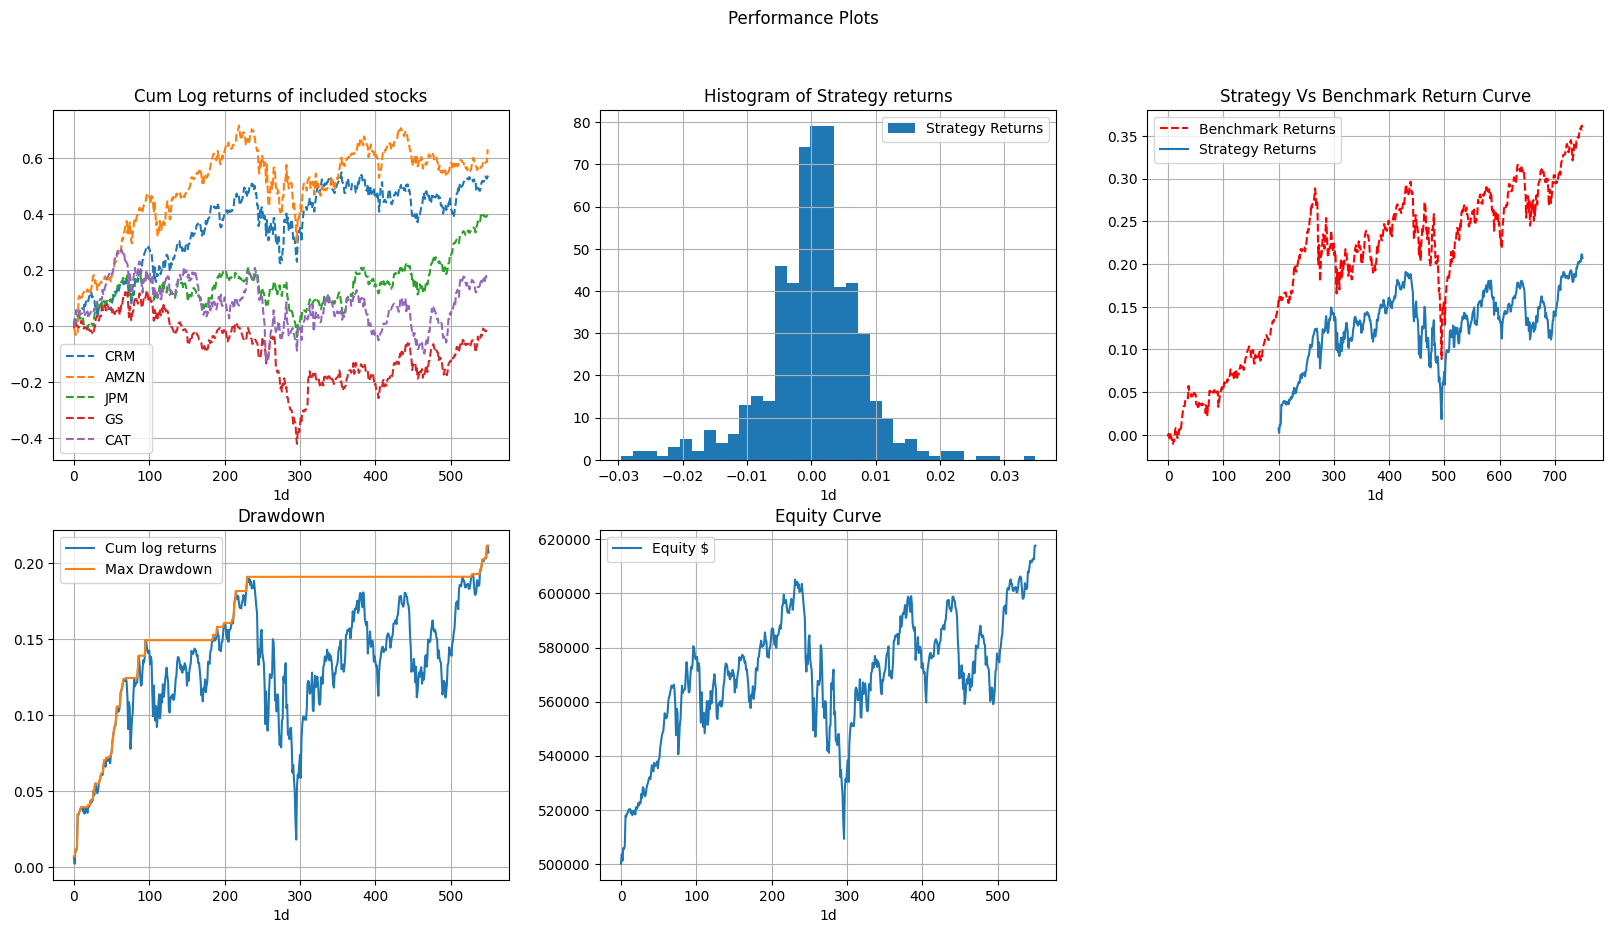

Performance Metrics for Benchmark
The total capital at end of Benchmark: 713617.3
The annual regular returns: 12.68 %
The annual regular std deviation: 13.18 %
The annual Sharpe Ratio: 0.96
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 42.7 %
The maximum drawdown: 20.79 %
The maximum drawdown period: 187.00 days
The annual Sortino Ratio: 1.12


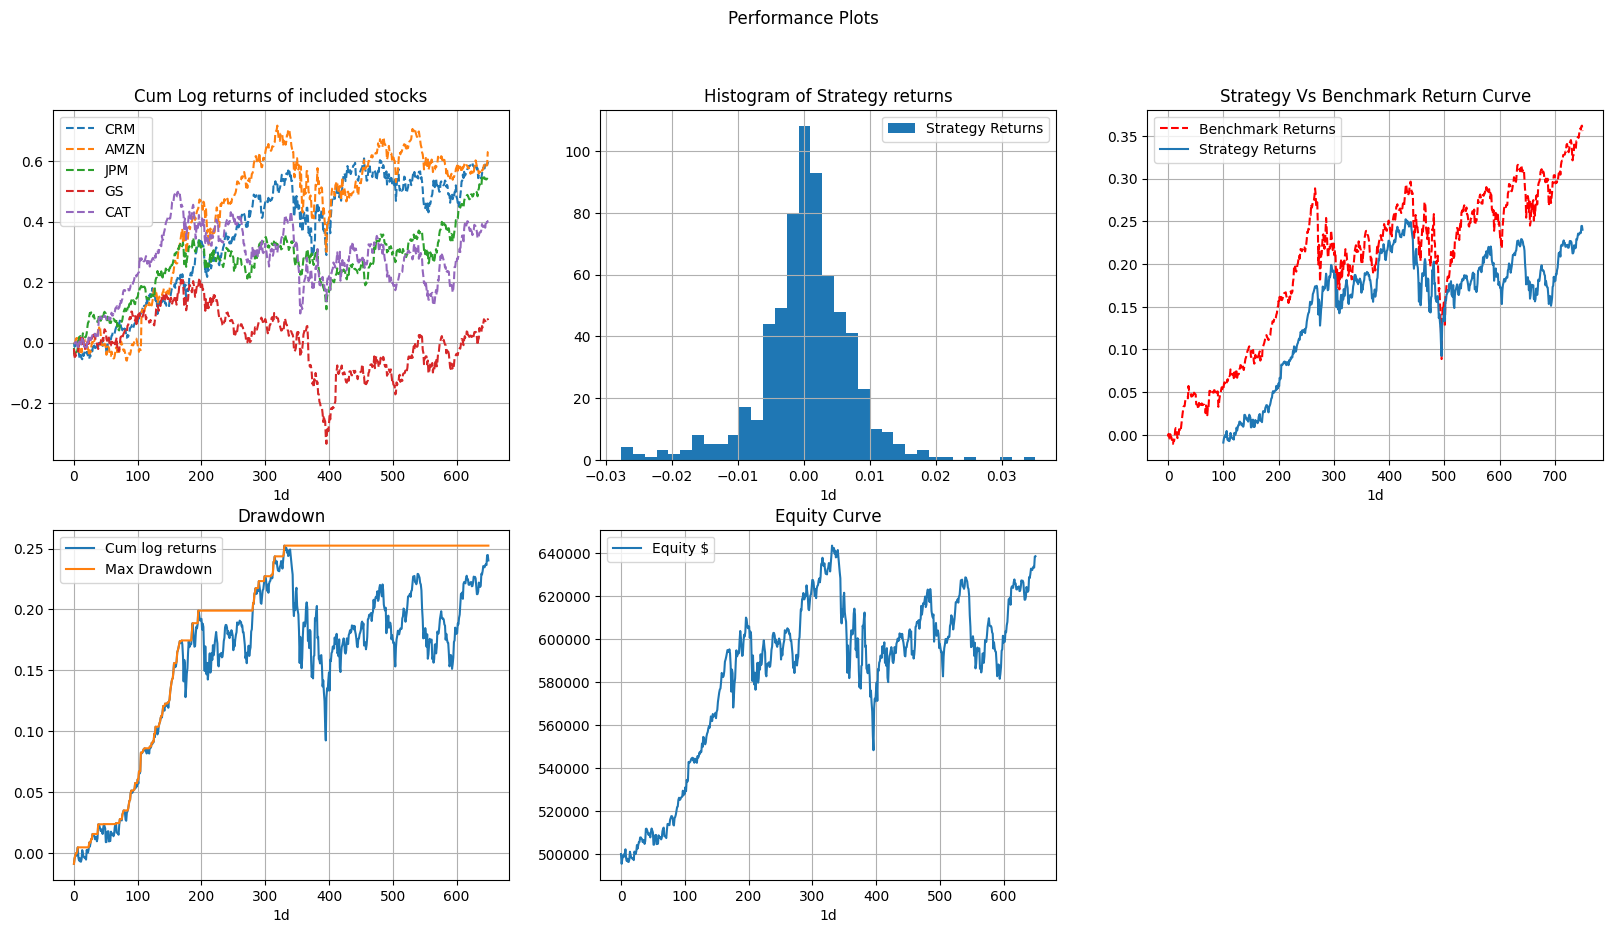

Performance Metrics
The total capital at end of strategy: 635796.4
The annual regular returns: 9.75 %
The annual regular std deviation: 11.10 %
The annual Sharpe Ratio: 0.88
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 27.2 %
The maximum drawdown: 16.01 %
The maximum drawdown period: 86.00 days
The annual Sortino Ratio: 1.10
The total trades taken by the strategy: 680


In [8]:
best_params_trade_all = copy.deepcopy(best_params)
pre_tuned_test = All_volatile(trading_stocks, hodl_stocks, testing_start, testing_end, "1d", initial_capital, 0.00, False)
pre_tuned_test.run_strategy(200, 20, 1.5, 14, 3, 3)

# Printing the performance metrics
pre_tuned_test.performance()
pre_tuned_test.performance_results()
pre_tuned_test.performance_plots()

# Running the strategy with the best parameters found for train
optimal_strategy_test = All_volatile(trading_stocks, hodl_stocks, testing_start, testing_end, "1d", initial_capital, 0.00, False)
optimal_strategy_test.run_strategy(best_params['ema_window'], best_params['bb_window'], best_params['bb_dev'], best_params['atr_window'], best_params['sl_multiplier'], best_params['tp_multiplier'])
optimal_strategy_test.performance()
optimal_strategy_test.performance_plots()
optimal_strategy_test.performance_results()

##### **Portfolio of Volatile + Buy-and-Hold Stable Stocks**

*80% volatile stocks;*
*20% buy-and-hold stocks*

In [9]:
class All_volatile_with_hodl(Common_Class):

    def update_trailing_sl(self, stock, price, atr, sl_multiplier):
        """Updates the trailing stop loss for a given stock based on ATR and stop loss multiplier."""
        
        old_stop_loss = self.stop_loss_price['{}'.format(stock)]
        if self.position['{}'.format(stock)] == 1:
            new_stop_loss = price - (atr * sl_multiplier)
            if new_stop_loss > old_stop_loss:
                self.stop_loss_price['{}'.format(stock)] = new_stop_loss

        if self.position['{}'.format(stock)] == -1:
            new_stop_loss = price + (atr * sl_multiplier)
            if new_stop_loss < old_stop_loss:
                self.stop_loss_price['{}'.format(stock)] = new_stop_loss

    def update_tp_sl(self, stock, price, atr, sl_multiplier, tp_multiplier):
        """Sets the initial stop loss and take profit for a given stock based on ATR, stop loss, and take profit multipliers."""
        
        if self.position['{}'.format(stock)] == 1:
            self.take_profit_price['{}'.format(stock)] = price + (tp_multiplier * atr)
            self.stop_loss_price['{}'.format(stock)] = price - (sl_multiplier * atr)

        if self.position['{}'.format(stock)] == -1:
            self.take_profit_price['{}'.format(stock)] = price - (tp_multiplier * atr)
            self.stop_loss_price['{}'.format(stock)] = price + (sl_multiplier * atr)

    def go_long(self, bar, stock, dollar, quantity=None):
        """Executes a long position for the specified stock, either closing short or opening a new position."""
        
        if self.position['{}'.format(stock)] == -1:
            self.position['{}'.format(stock)] = 0
            self.buy_order(bar, stock, quantity=-self.quantity['{}'.format(stock)])
        if quantity:
            self.buy_order(bar, stock, quantity=quantity)
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
            self.buy_order(bar, stock, dollar=dollar)

    def go_short(self, bar, stock, dollar, quantity=None):
        """Executes a short position for the specified stock, either closing long or opening a new position."""
        
        if self.position['{}'.format(stock)] == 1:
            self.position['{}'.format(stock)] = 0
            self.sell_order(bar, stock, quantity=self.quantity['{}'.format(stock)])
        if quantity:
            self.sell_order(bar, stock, quantity=quantity)
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
            self.sell_order(bar, stock, dollar=dollar)

    def stop_loss(self):
        """Placeholder for stop loss functionality."""
        pass

    def take_profit(self):
        """Placeholder for take profit functionality."""
        pass

    def conditionGenerator(self, ema, bb_low, bb_high, close_price, bar):
        """Generates trading conditions based on EMA and Bollinger Bands for long or short positions."""
        
        if close_price.iloc[bar] < bb_low.iloc[bar] and close_price.iloc[bar] > ema.iloc[bar]:
            return 1  # Condition to go long
        elif close_price.iloc[bar] > bb_high.iloc[bar] and close_price.iloc[bar] < ema.iloc[bar]:
            return -1  # Condition to go short
        else:
            return 1

    def run_strategy(self, ema, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier):
        """Runs the trading strategy using specified indicators and parameters, including handling hodl and trading stocks."""
        
        self.hodl_capital = 0.2 * self.initial_capital
        self.trading_capital = self.initial_capital - self.hodl_capital
        self.stop = False
        self.trades = 0
        self.capital = self.initial_capital

        self.take_profit_price = {}
        self.stop_loss_price = {}

        # Initializing ATR, stop loss, and take profit multipliers
        atr_window = 14
        sl_multiplier = 3
        tp_multiplier = 3

        # Preparing data with indicators for each stock
        for stock in self.symbol:
            self.quantity['{}'.format(stock)] = 0
            self.position['{}'.format(stock)] = 0
            self.take_profit_price['{}'.format(stock)] = 0
            self.stop_loss_price['{}'.format(stock)] = 0
            
            # Calculate EMA for each stock
            self.all_data[stock]['EMA'] = self.all_data[stock]['Close_Price'].ewm(span=ema, adjust=False).mean()

            # Calculate Bollinger Bands for each stock
            bollingerbands = BollingerBands(self.all_data[stock]['Close_Price'], window=bb_window, window_dev=bb_dev)
            high = bollingerbands.bollinger_hband()
            low = bollingerbands.bollinger_lband()
            mid = bollingerbands.bollinger_mavg()

            self.all_data[stock]['bb_high'] = high
            self.all_data[stock]['bb_low'] = low
            self.all_data[stock]['bb_mid'] = mid

            # Calculate ATR for each stock
            indicator_atr = AverageTrueRange(high=self.all_data[stock]['High_Price'],
                                             low=self.all_data[stock]['Low_Price'],
                                             close=self.all_data[stock]['Close_Price'],
                                             window=atr_window, fillna=False)
            atr = indicator_atr.average_true_range()
            self.all_data[stock]['ATR'] = atr

        # Running the strategy for each bar from the beginning to the last available data bar
        for bar in range(0, len(self.all_data['{}'.format(self.symbol[0])])):
            tb = self.total_balance(bar)
            if tb < 0:
                print("negative capital")
                self.last_trade(bar)
                self.stop = True
                break

            # Buy hodl stocks at the beginning (first bar)
            if bar == 0:
                for stock in self.symbol:
                    date, price = self.return_date_price(bar, stock)
                    if stock in self.hodl_stocks:
                        self.go_long(0, stock, dollar=self.hodl_capital / len(self.hodl_stocks))
                    else:
                        store_quantity = abs(self.quantity['{}'.format(stock)])
                        tb = self.total_balance(0)
                        self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)

            # Running the strategy for each trading stock after EMA data is available
            for stock in self.symbol:
                date, price = self.return_date_price(bar, stock)
                if bar == 0:  # Buy hodl stocks on the first day
                    if stock in self.hodl_stocks:
                        self.go_long(0, stock, dollar=self.hodl_capital / len(self.hodl_stocks))
                    else:
                        store_quantity = abs(self.quantity['{}'.format(stock)])
                        tb = self.total_balance(0)
                        self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)
                elif bar >= ema and stock in trading_stocks:  # Start trading when EMA data is available
                    tp = self.take_profit_price['{}'.format(stock)]
                    sl = self.stop_loss_price['{}'.format(stock)]
                    curr_atr = self.all_data[stock]['ATR'].iloc[bar]
                    num_of_stocks_with_no_position = sum(1 for key, value in self.position.items() if key in trading_stocks and value == 0)
                    if num_of_stocks_with_no_position != 0:
                        amount_to_trade = self.trading_capital / num_of_stocks_with_no_position
                    else:
                        amount_to_trade = self.trading_capital / len(self.position)

                    # Check take profit or stop loss for long positions
                    if self.position[stock] == 1:
                        if price >= tp or price <= sl:
                            self.sell_order(bar, stock, quantity=self.quantity[stock])
                            self.position[stock] = 0

                    # Check take profit or stop loss for short positions
                    if self.position[stock] == -1:
                        if price <= tp or price >= sl:
                            self.buy_order(bar, stock, quantity=-self.quantity[stock])
                            self.position[stock] = 0

                    # Update trailing stop loss if in a position
                    if self.position[stock] in [1, -1]:
                        self.update_trailing_sl(stock, price, curr_atr, sl_multiplier)

                    # Generate conditions to go long if no position or short
                    if self.position[stock] in [0, -1]:
                        if self.conditionGenerator(self.all_data[stock]['EMA'], self.all_data[stock]['bb_low'],
                                                   self.all_data[stock]['bb_high'], self.all_data[stock]['Close_Price'],
                                                   bar) == 1:
                            self.go_long(bar, stock, dollar=amount_to_trade)
                            self.update_tp_sl(stock, price, curr_atr, sl_multiplier, tp_multiplier)
                            continue

                    # Generate conditions to go short if no position or long
                    if self.position[stock] in [0, 1]:
                        if self.conditionGenerator(self.all_data[stock]['EMA'], self.all_data[stock]['bb_low'],
                                                   self.all_data[stock]['bb_high'], self.all_data[stock]['Close_Price'],
                                                   bar) == -1:
                            self.go_short(bar, stock, dollar=amount_to_trade)
                            self.update_tp_sl(stock, price, curr_atr, sl_multiplier, tp_multiplier)
                            continue

                # Store trade details for further analysis
                store_quantity = abs(self.quantity[stock])
                tb = self.total_balance(bar)
                self.store_results(0, date, self.position[stock], price, stock, store_quantity, tb)

        # Closing all trades at the end of the last bar
        if not self.stop:
            self.last_trade(bar)


Performance Metrics for Benchmark
The total capital at end of Benchmark: 934665.3
The annual regular returns: 9.37 %
The annual regular std deviation: 14.43 %
The annual Sharpe Ratio: 0.65
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 86.9 %
The maximum drawdown: 18.42 %
The maximum drawdown period: 289.00 days
The annual Sortino Ratio: 0.86
Performance Metrics
The total capital at end of strategy: 1738187.1
The annual regular returns: 19.55 %
The annual regular std deviation: 20.99 %
The annual Sharpe Ratio: 0.93
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 247.6 %
The maximum drawdown: 26.61 %
The maximum drawdown period: 277.00 days
The annual Sortino Ratio: 1.35
The total trades taken by the strategy: 877


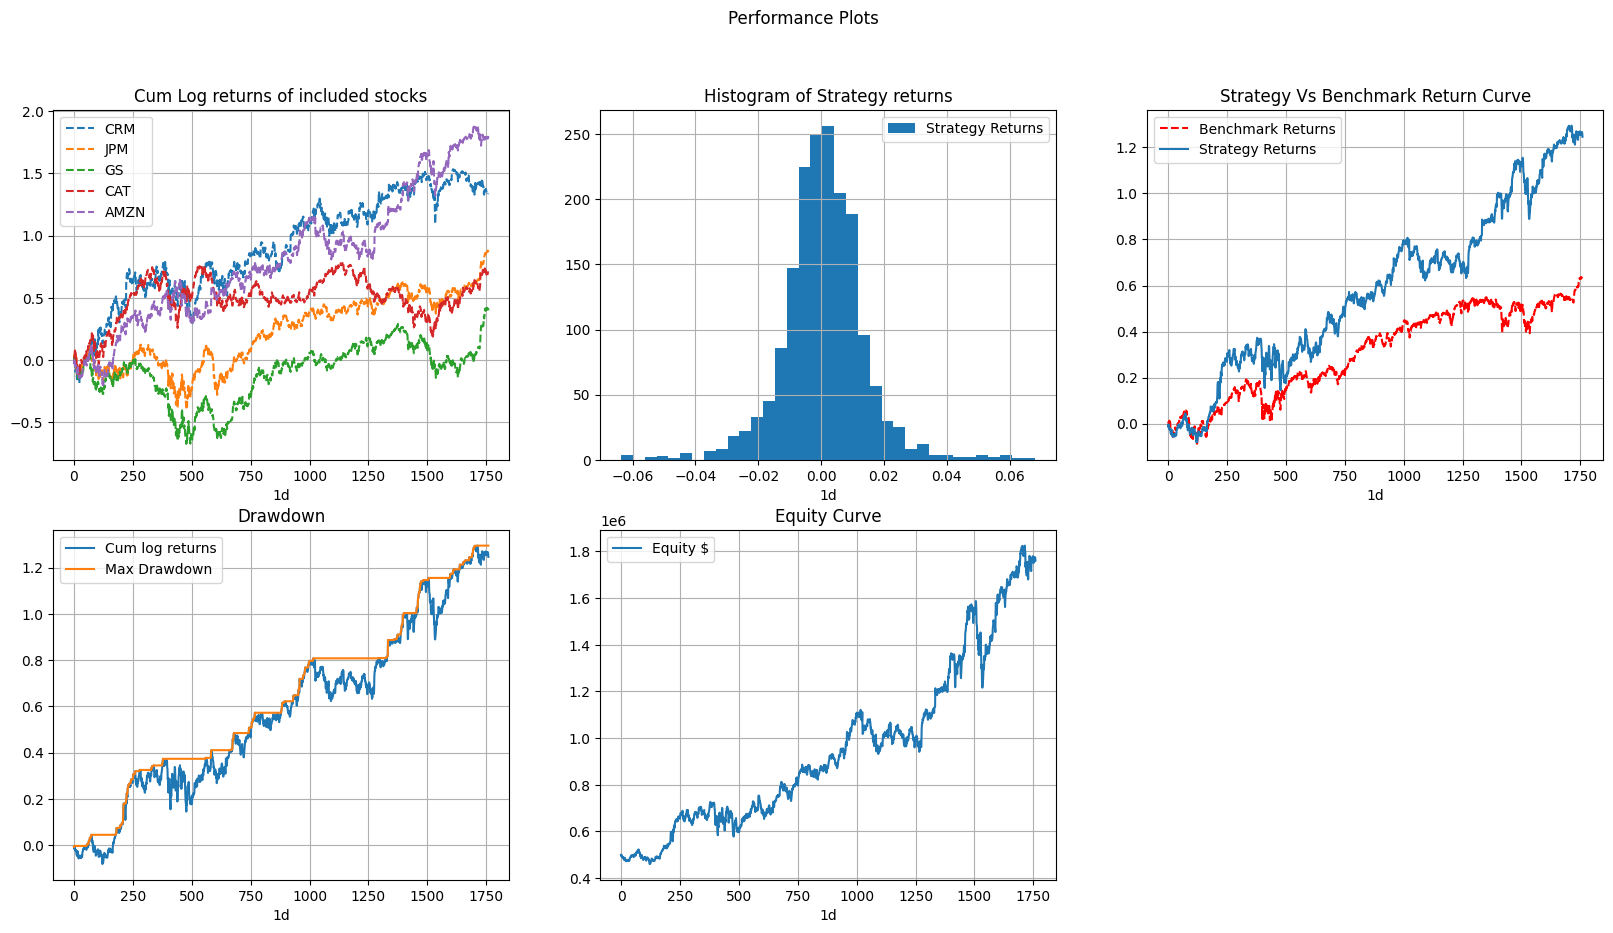

Performance Metrics for Benchmark
The total capital at end of Benchmark: 934665.3
The annual regular returns: 9.37 %
The annual regular std deviation: 14.43 %
The annual Sharpe Ratio: 0.65
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 86.9 %
The maximum drawdown: 18.42 %
The maximum drawdown period: 289.00 days
The annual Sortino Ratio: 0.86
Performance Metrics for Benchmark
The total capital at end of Benchmark: 934665.3
The annual regular returns: 9.37 %
The annual regular std deviation: 14.43 %
The annual Sharpe Ratio: 0.65
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 86.9 %
The maximum drawdown: 18.42 %
The maximum drawdown period: 289.00 days
The annual Sortino Ratio: 0.86
Performance Metrics for Benchmark
The total capital at end of Benchmark: 934665.3
The annual regular returns: 9.37 %
The annual regular std deviation: 14.43 %
The annual Sharpe Ratio: 0.65
The returns on investment from 2010-01-01 to 2016-12-31 by this

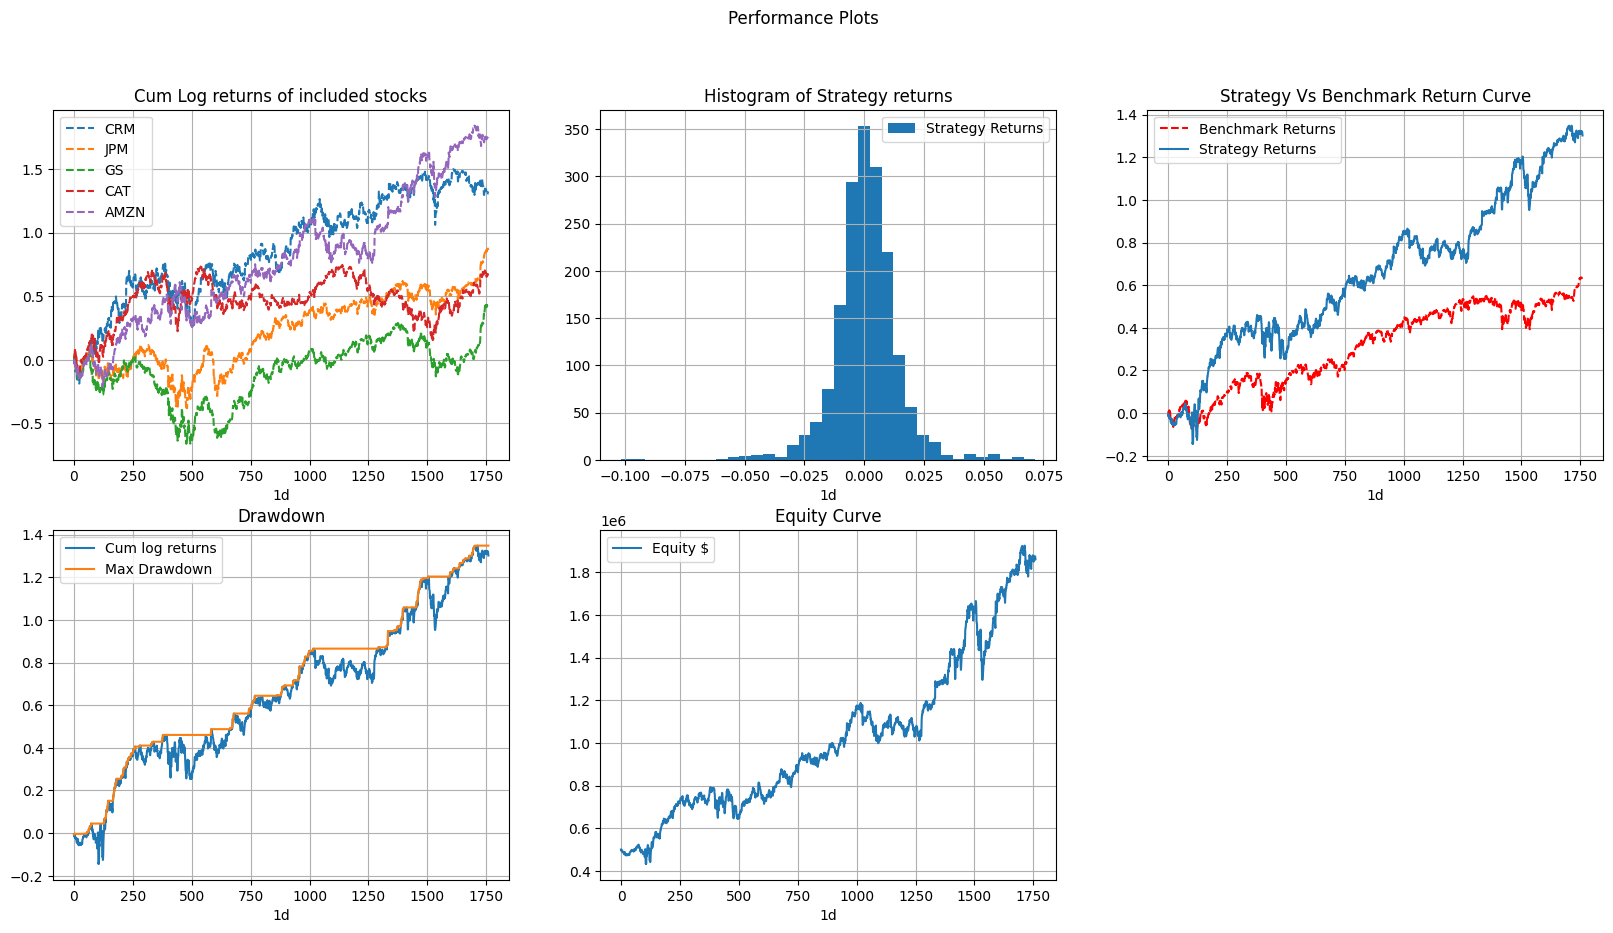

Performance Metrics
The total capital at end of strategy: 1838444.3
The annual regular returns: 20.49 %
The annual regular std deviation: 21.32 %
The annual Sharpe Ratio: 0.96
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 267.7 %
The maximum drawdown: 25.10 %
The maximum drawdown period: 277.00 days
The annual Sortino Ratio: 1.32
The total trades taken by the strategy: 1065


In [10]:
warnings.simplefilter(action='ignore', category=FutureWarning)

if __name__ == "__main__":
    """
    Main execution block for running the trading strategy, evaluating performance, and finding the optimal parameters.
    """

    # Setting initial parameters for capital, training, and testing periods
    initial_capital = 500000
    training_start = "2010-01-01"
    training_end = "2016-12-31"
    testing_start = "2017-01-01"
    testing_end = "2019-12-31"
    
    # List of trading stocks and holding stocks
    trading_stocks = ['CRM', 'JPM', 'GS', 'CAT']
    hodl_stocks = ['AMZN']
    
    # Defining parameter grid for the strategy
    param_grid = {
        'ema_window': [50, 100, 150, 200],
        'bb_window': [10, 15, 20, 25, 30], 
        'bb_dev': [1, 1.5, 2, 2.5, 3],
        'atr_window': [5, 10, 14, 20, 25],
        'sl_multiplier': [1, 1.5, 2, 2.5, 3], 
        'tp_multiplier': [1, 1.5, 2, 2.5, 3]   
    }

    # Running the strategy with specific parameters
    B = All_volatile_with_hodl(trading_stocks, hodl_stocks, training_start, training_end, "1d", initial_capital, 0.00, False)
    B.run_strategy(200, 20, 1.5, 14, 3, 3)
    total_return = B.capital - initial_capital

    # Printing the performance metrics
    B.performance()
    B.performance_results()
    B.performance_plots()

    # Finding the best parameters using randomized cross-validation search
    best_params = randomized_cv_search(All_volatile_with_hodl, param_grid, trading_stocks, hodl_stocks, training_start, training_end, initial_capital, n_iter=500)
    
    # Running the strategy with the best parameters found
    optimal_strategy_hold = All_volatile_with_hodl(trading_stocks, hodl_stocks, training_start, training_end, "1d", initial_capital, 0.00, False)
    optimal_strategy_hold.run_strategy(best_params['ema_window'], best_params['bb_window'], best_params['bb_dev'], best_params['atr_window'], best_params['sl_multiplier'], best_params['tp_multiplier'])
    optimal_strategy_hold.performance()
    optimal_strategy_hold.performance_plots()
    optimal_strategy_hold.performance_results()


Performance Metrics
The total capital at end of strategy: 1738187.1
The annual regular returns: 19.55 %
The annual regular std deviation: 20.99 %
The annual Sharpe Ratio: 0.93
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 247.6 %
The maximum drawdown: 26.61 %
The maximum drawdown period: 277.00 days
The annual Sortino Ratio: 1.35
The total trades taken by the strategy: 877


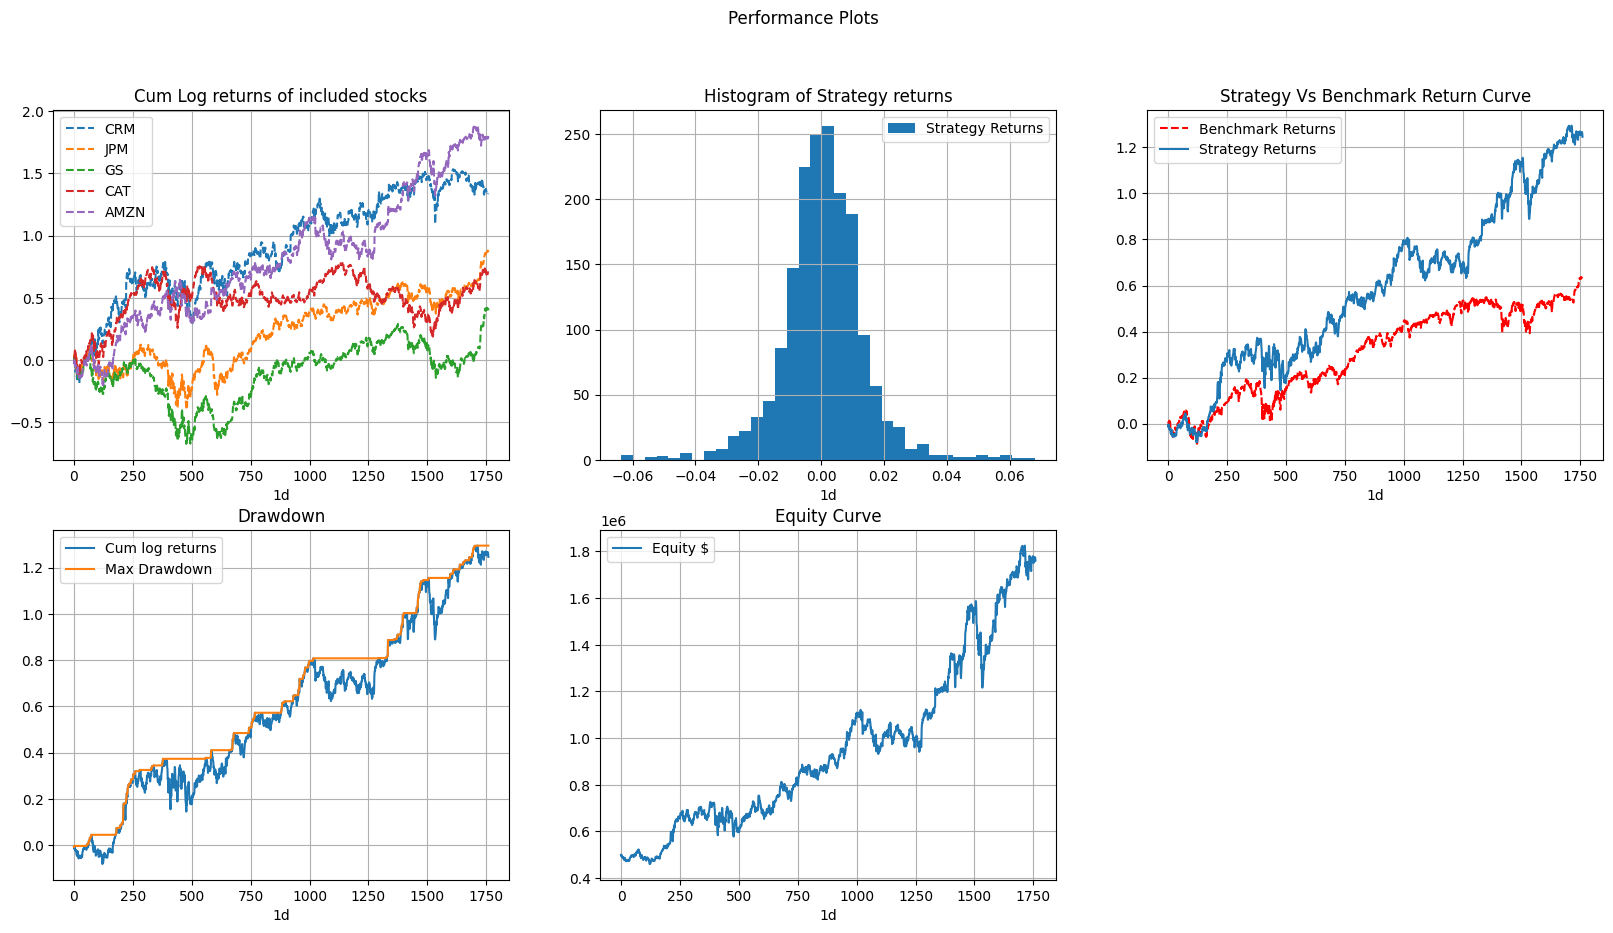

In [13]:
B.performance_results()
B.performance_plots()

##### **Portfolio of Volatile + Buy-and-Hold Stable Stocks Testing Period**


Performance Metrics for Benchmark
The total capital at end of Benchmark: 713617.3
The annual regular returns: 12.68 %
The annual regular std deviation: 13.18 %
The annual Sharpe Ratio: 0.96
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 42.7 %
The maximum drawdown: 20.79 %
The maximum drawdown period: 187.00 days
The annual Sortino Ratio: 1.12
Performance Metrics
The total capital at end of strategy: 905411.0
The annual regular returns: 22.05 %
The annual regular std deviation: 19.89 %
The annual Sharpe Ratio: 1.11
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 81.1 %
The maximum drawdown: 33.13 %
The maximum drawdown period: 63.00 days
The annual Sortino Ratio: 1.39
The total trades taken by the strategy: 305


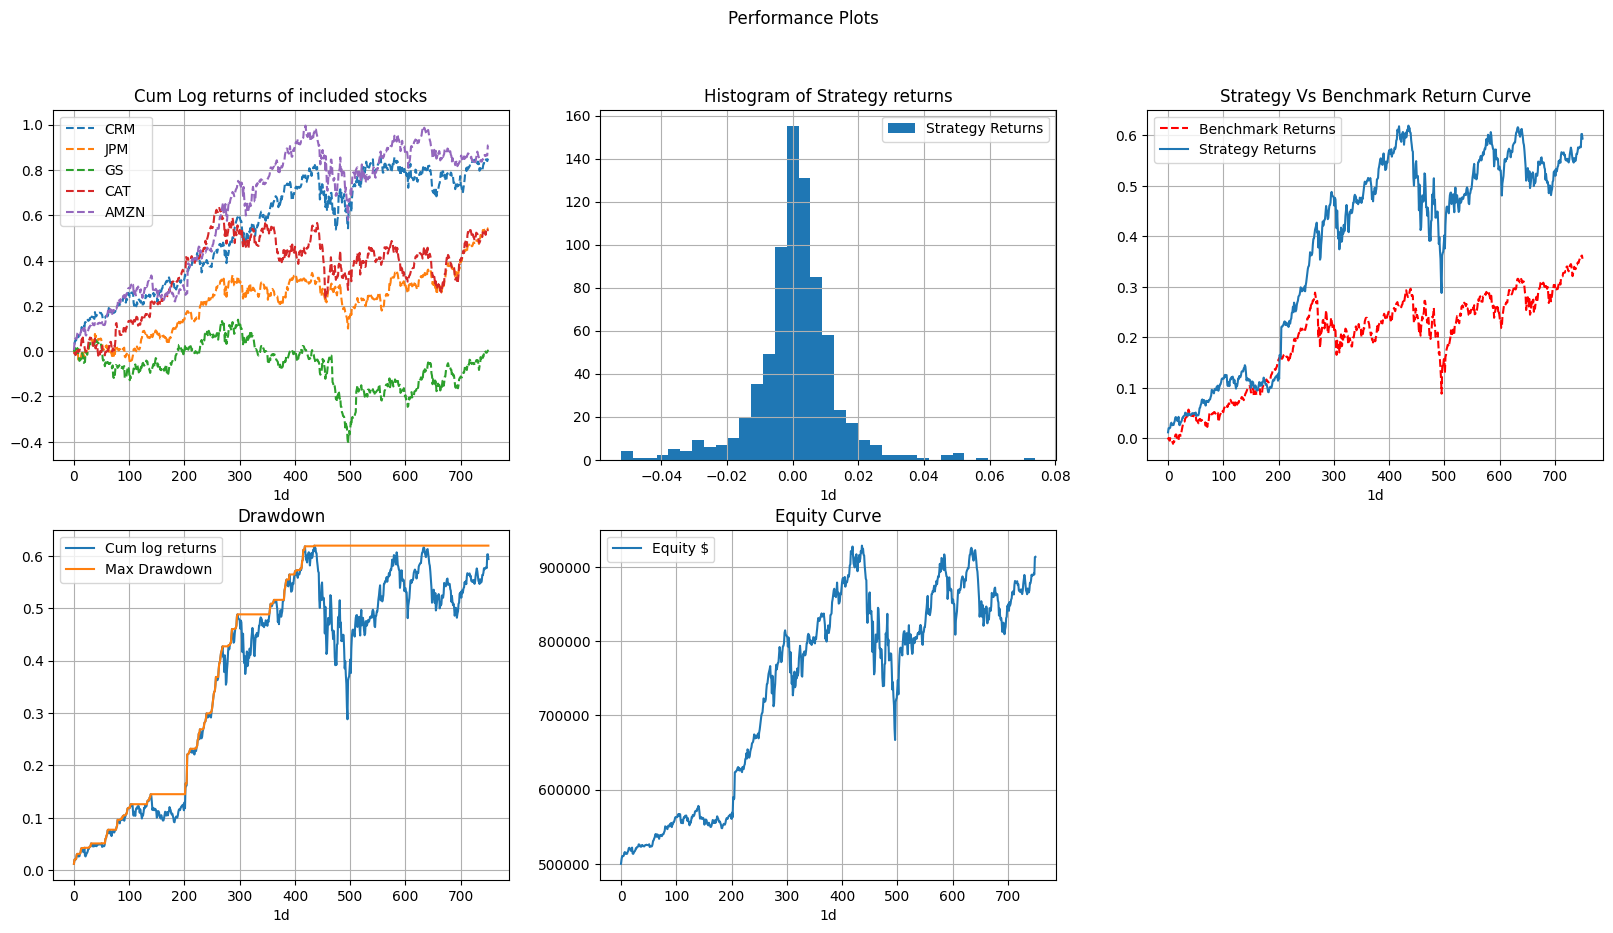

Performance Metrics for Benchmark
The total capital at end of Benchmark: 713617.3
The annual regular returns: 12.68 %
The annual regular std deviation: 13.18 %
The annual Sharpe Ratio: 0.96
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 42.7 %
The maximum drawdown: 20.79 %
The maximum drawdown period: 187.00 days
The annual Sortino Ratio: 1.12


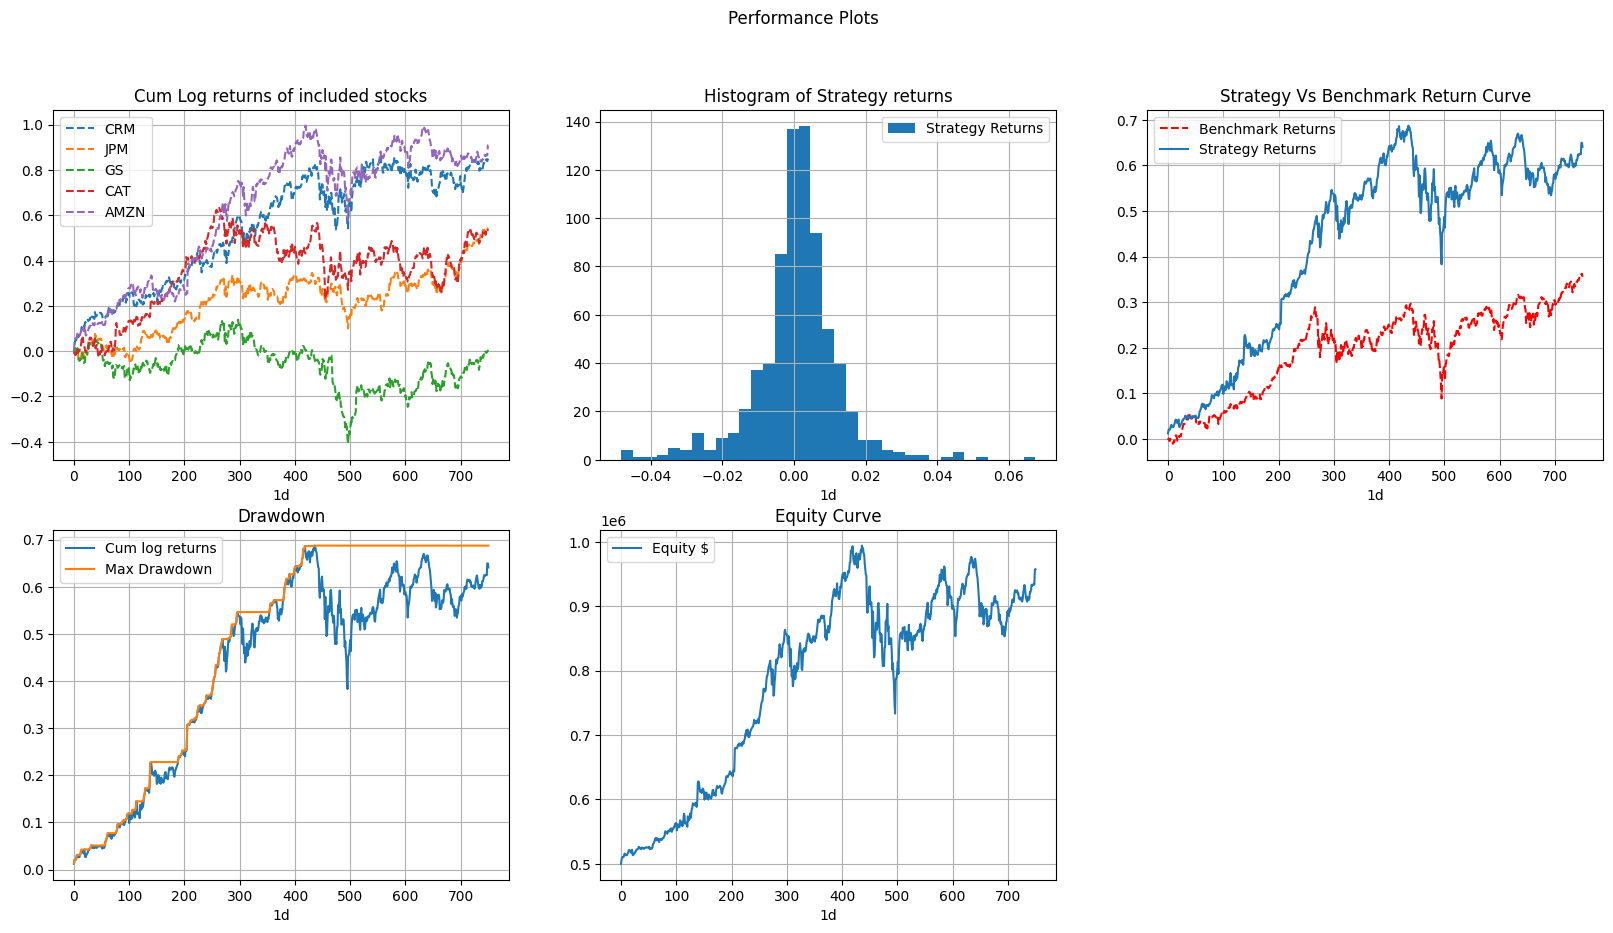

Performance Metrics
The total capital at end of strategy: 949068.9
The annual regular returns: 23.99 %
The annual regular std deviation: 18.91 %
The annual Sharpe Ratio: 1.27
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 89.8 %
The maximum drawdown: 30.42 %
The maximum drawdown period: 58.00 days
The annual Sortino Ratio: 1.60
The total trades taken by the strategy: 379


In [11]:
best_params_hold = copy.deepcopy(best_params)
pre_tuned_hold_test = All_volatile_with_hodl(trading_stocks, hodl_stocks, testing_start, testing_end, "1d", initial_capital, 0.00, False)
pre_tuned_hold_test.run_strategy(200, 20, 1.5, 14, 3, 3)

# Printing the performance metrics
pre_tuned_hold_test.performance()
pre_tuned_hold_test.performance_results()
pre_tuned_hold_test.performance_plots()

# Running the strategy with the best parameters found for train
optimal_strategy_hold_test = All_volatile_with_hodl(trading_stocks, hodl_stocks, testing_start, testing_end, "1d", initial_capital, 0.00, False)
optimal_strategy_hold_test.run_strategy(best_params['ema_window'], best_params['bb_window'], best_params['bb_dev'], best_params['atr_window'], best_params['sl_multiplier'], best_params['tp_multiplier'])
optimal_strategy_hold_test.performance()
optimal_strategy_hold_test.performance_plots()
optimal_strategy_hold_test.performance_results()